# Brazilian economics data web scraping

Notebook to automate the collecting process of various economics temporal series.

In [1]:
#importing the libs
import pandas as pd
#import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from datetime import datetime
import calendar
from ftplib import FTP
import zipfile

### CDI

In [2]:
url_cdi = 'http://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-de-segmentos-e-setoriais/serie-historica-do-di.htm'

In [3]:
#TODO

### IPCA

IPCA (Índice de preços ao consumidor amplo/Broad Consumer Price Index) is the official Brazilian inflation index. It is calculated on a monthly basis by the IBGE (Instituto Brasileiro de Geografia e Estatística/Brazilian Institute of Geography and Statistics - https://www.ibge.gov.br/), it is provided as temporal series since January 1994 in: https://ftp.ibge.gov.br/Precos_Indices_de_Precos_ao_Consumidor/IPCA/Serie_Historica/ipca_SerieHist.zip.

Below code downloads and clean-up the series provided by IBGE:

Download raw .zip from IBGE FTP -> unzip -> load into a DataFrame -> clean-up -> save the cleaned data in a local repository as .xlsx (MS Excel)


In [4]:
# ipca scraper config
# url: https://ftp.ibge.gov.br/Precos_Indices_de_Precos_ao_Consumidor/IPCA/Serie_Historica/ipca_SerieHist.zip
IPCA_scraper_config = pd.Series({ 'url_ipca' : 'ftp.ibge.gov.br',
                                  'username_ipca' : '',
                                  'password_ipca' : '',
                                  'remote_path_ipca' : '/Precos_Indices_de_Precos_ao_Consumidor/IPCA/Serie_Historica',
                                  'remote_file_ipca' : 'ipca_SerieHist.zip',
                                  'local_path_ipca' : ''})

In [5]:
#create a folder
def create_folder_if_not_exists(folder_path):
    try:
        # Check if the folder exists
        if not os.path.exists(folder_path):
            # If not, create the folder
            os.makedirs(folder_path)
            print(f"Folder '{folder_path}' created successfully.")
        else:
            print(f"Folder '{folder_path}' already exists.")

    except Exception as e:
        print(f"Error: {e}")

In [6]:
#download data from FTP
def download_ftp_data(url, username, password, remote_path, remote_file, local_path):
    try:
        # Connect to the FTP server
        ftp = FTP(url)
        ftp.login(username, password)

        # Change to the remote directory
        ftp.cwd(remote_path)

        # Open a local file for writing
        with open(local_path+'/'+remote_file, 'wb') as local_file:
            # Retrieve the file from the FTP server
            ftp.retrbinary('RETR ' + remote_file, local_file.write)

        print(f"File downloaded successfully to {local_path}")

    except Exception as e:
        print(f"Error: {e}")

    finally:
        # Close the FTP connection
        if ftp:
            ftp.quit()

In [7]:
#unzip a file
def unzip(file_path, file_name):
    try:
        with zipfile.ZipFile(file_path+'/'+file_name, 'r') as zip_ref:
            zip_ref.extractall(file_path)
        print(f"File unziped successfully to {file_path}")
        
    except Exception as e:
        print(f"Error: {e}")       

In [8]:
#scraper to colect, clean and save the ipca data
def scrap_IPCA(config):
    #get the timestamp and create a folder to store the downloaded raw data
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    config.local_path_ipca = 'raw_data/'+'ipca_raw_'+timestamp
    create_folder_if_not_exists('raw_data')
    create_folder_if_not_exists(config.local_path_ipca)
    
    #download the ipca raw data (.zip) from IBGE FTP to local_path folder
    download_ftp_data(config.url_ipca, config.username_ipca, config.password_ipca, config.remote_path_ipca, config.remote_file_ipca, config.local_path_ipca)
    
    #unzip the file (.xls file expected)
    unzip(config.local_path_ipca, config.remote_file_ipca)
    
    #load excel file as a DataFrame
    try:
        files = os.listdir(config.local_path_ipca)
        # Find the Excel file (assuming there's only one)
        excel_file = next((file for file in files if file.endswith(('.xls', '.xlsx'))), None)
        if excel_file:
            # If there's an Excel file, open it with pandas
            excel_file_path = os.path.join(config.local_path_ipca, excel_file)
            df = pd.read_excel(excel_file_path)
            print("Excel file successfully loaded.")
        else:
            print(f"No excel file found in {local_path}")
    except Exception as e:
        print(f"Error: {e}")
    
    #clean-up the data loaded
    df_ok = df.copy().rename(columns={'Unnamed: 0':'ref_year', 'Unnamed: 1':'ref_month' , 'Unnamed: 3':'in_month', 'Unnamed: 4':'in_3_months', 'Unnamed: 5':'in_6_months', 'Unnamed: 6':'in_year', 'Unnamed: 7':'in_12_months'}).drop(columns='Unnamed: 2')
    df_ok = df_ok.replace({'JAN':1, 'FEV':2, 'MAR':3, 'ABR':4, 'MAI':5, 'JUN':6, 'JUL':7, 'AGO':8, 'SET':9, 'OUT':10, 'NOV':11, 'DEZ':12}).replace({' ':pd.NA})
    df_ok['ref_year'] = df_ok['ref_year'].fillna(axis='index', method='ffill')
    df_ok = df_ok.dropna(how='any').reset_index(drop = True)
    #pd.set_option('display.max_rows', None)

    #adding some useful columns
    df_ok.insert(2,'ref_last_day', df_ok.apply(lambda row: calendar.monthrange(row['ref_year'], row['ref_month'])[1], axis=1))
    df_ok.insert(3, 'ref_date', pd.to_datetime(df_ok['ref_last_day'].astype(str) + '-' + df_ok['ref_month'].astype(str) + '-' + df_ok['ref_year'].astype(str), dayfirst=True, format='%d-%m-%Y'))
    df_ok = df_ok.set_index(['ref_year','ref_month'])
    print("DataFrame cleaned.")
    
    #store the cleaned DF in a MS Excel file
    try:
        df_ok.to_excel(config.local_path_ipca + '/' + "ipca_hist_series.xlsx", merge_cells=False)  
        
    except Exception as e:
        print(f"Error: {e}")
    
    return df_ok

In [9]:
#executing the scraper
ipca_df = scrap_IPCA(IPCA_scraper_config)
ipca_df
#example of filter to get an specific value from the DF: ipca_df['in_12_months'].loc[2003,4]

Folder 'raw_data' already exists.
Folder 'raw_data/ipca_raw_20231125_140536' created successfully.
File downloaded successfully to raw_data/ipca_raw_20231125_140536
File unziped successfully to raw_data/ipca_raw_20231125_140536
Excel file successfully loaded.
DataFrame cleaned.


ref_last_day   ref_date in_month in_3_months in_6_months  \
ref_year ref_month                                                             
1994     1                    31 1994-01-31    41.31      162.13      533.33   
         2                    28 1994-02-28    40.27      171.24      568.17   
         3                    31 1994-03-31    42.75      182.96      602.93   
         4                    30 1994-04-30    42.68      185.71      648.92   
         5                    31 1994-05-31    44.03      193.36      695.71   
...                          ...        ...      ...         ...         ...   
2023     6                    30 2023-06-30    -0.08        0.76        2.87   
         7                    31 2023-07-31     0.12        0.27        2.45   
         8                    31 2023-08-31     0.23        0.27        1.83   
         9                    30 2023-09-30     0.26        0.61        1.38   
         10                   31 2023-10-31     0.24        0.73           1   

                   in_year in_12_months  
ref_year ref_month                       
1994     1           41.31      2693.84  
         2           98.22      3035.71  
         3          182.96      3417.39  
         4          303.73      3828.49  
         5          481.49      4331.19  
...                    ...          ...  
2023     6            2.87         3.16  
         7            2.99         3.99  
         8            3.23         4.61  
         9             3.5         5.19  
         10           3.75         4.82  

[358 rows x 7 columns]

In [10]:
#reading the recently saved clean database from excel
df = pd.read_excel(IPCA_scraper_config.local_path_ipca + '/' + "ipca_hist_series.xlsx").set_index(['ref_year','ref_month'])
df

ref_last_day   ref_date  in_month  in_3_months  \
ref_year ref_month                                                   
1994     1                    31 1994-01-31     41.31       162.13   
         2                    28 1994-02-28     40.27       171.24   
         3                    31 1994-03-31     42.75       182.96   
         4                    30 1994-04-30     42.68       185.71   
         5                    31 1994-05-31     44.03       193.36   
...                          ...        ...       ...          ...   
2023     6                    30 2023-06-30     -0.08         0.76   
         7                    31 2023-07-31      0.12         0.27   
         8                    31 2023-08-31      0.23         0.27   
         9                    30 2023-09-30      0.26         0.61   
         10                   31 2023-10-31      0.24         0.73   

                    in_6_months  in_year  in_12_months  
ref_year ref_month                                      
1994     1               533.33    41.31       2693.84  
         2               568.17    98.22       3035.71  
         3               602.93   182.96       3417.39  
         4               648.92   303.73       3828.49  
         5               695.71   481.49       4331.19  
...                         ...      ...           ...  
2023     6                 2.87     2.87          3.16  
         7                 2.45     2.99          3.99  
         8                 1.83     3.23          4.61  
         9                 1.38     3.50          5.19  
         10                1.00     3.75          4.82  

[358 rows x 7 columns]

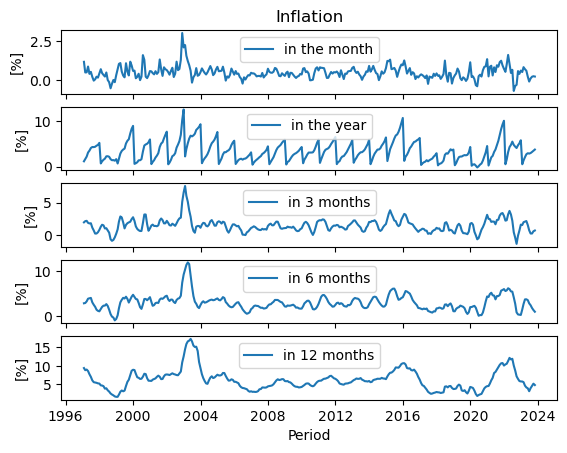

In [11]:
#ploting the DataFrame
#ploting from '96 to avoid the "94'-ish pollution" 

#fig_size = plt.rcParams["figure.figsize"]
#fig_size = (20,50)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5, ncols = 1, sharex = True)

start = 1997
end = 2023

ax1.plot(ipca_df.ref_date.loc[start:end], ipca_df.in_month.loc[start:end], label = 'in the month')
ax2.plot(ipca_df.ref_date.loc[start:end], ipca_df.in_year.loc[start:end], label = 'in the year')
ax3.plot(ipca_df.ref_date.loc[start:end], ipca_df.in_3_months.loc[start:end], label = 'in 3 months')
ax4.plot(ipca_df.ref_date.loc[start:end], ipca_df.in_6_months.loc[start:end], label = 'in 6 months')
ax5.plot(ipca_df.ref_date.loc[start:end], ipca_df.in_12_months.loc[start:end], label = 'in 12 months')

#x axis settings
ax1.set_title('Inflation')
ax5.set_xlabel('Period')

#y axis settings
ax1.set_ylabel('[%]')
ax2.set_ylabel('[%]')
ax3.set_ylabel('[%]')
ax4.set_ylabel('[%]')
ax5.set_ylabel('[%]')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()

#plt.tight_layout()
plt.show()

### IGP-M

In [12]:
url_igpm = 'https://portal.fgv.br/noticias/igpm-resultados-2022'

In [13]:
#TODO